In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import ccf_streamlines.projection as ccfproj

import sys
# import ../utils
sys.path.append('../')
from utils import reflect_points_to_left

### Get flatmap lines and area annotations

In [3]:
data_dir = os.environ.get('ROOT_DATA_PATH')
ccf_files_path = os.path.join(data_dir, "CCF_files")

space = "flatmap_butterfly"
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,f"{space}.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)
bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()


# move up the hierarchy to get rid of the smallest 'areas' which are actually layers
with open('../../data/files/area_ancestor_id_map.json', 'r') as f:
    area_ancestor_id_map = json.load(f)
with open('../../data/files/area_name_map.json', 'r') as f:
    area_name_map = json.load(f)
area_name_map['0'] = 'outside_brain'
annotation2area_int = {0.0:0} # Map from annotation id to area id. Float to int
for a in area_ancestor_id_map.keys(): 
    higher_area_id = area_ancestor_id_map[str(int(a))][1] if len(area_ancestor_id_map[str(int(a))])>1 else a    
    annotation2area_int[float(a)] = higher_area_id

unique_areas = np.unique(list(annotation2area_int.values())) # List of unique areas (noncontiguous ints)
unique_annos = [area_name_map[str(int(a))] for a in unique_areas] # List of unique area names
area_classes = np.arange(len(unique_areas)) # Create a class for each area (0, 1, 2, ...)
id2id = {float(k):v for (k,v) in zip(unique_areas, area_classes)} # Map from area id to class id
annoation2area_class = {k: id2id[int(v)] for k,v in annotation2area_int.items()} # Map from annotation to area class
id2id_rev = {v:k for k,v in id2id.items()} # Map from class id to area id
area_class2area_name = {k: area_name_map[str(int(v))] for k,v in id2id_rev.items()} # Map from area class to area name




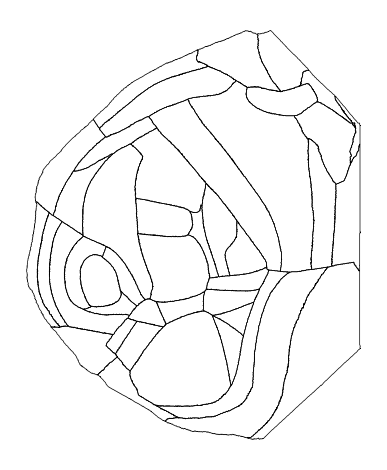

In [4]:
for k, boundary_coords in bf_left_boundaries_flat.items():
    plt.plot(*boundary_coords.T, c="k", lw=0.5)

ax = plt.gca()
ax.invert_yaxis()

plt.axis('off')
# plt.grid()
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("boundaries.png")

## Fig 2a

Slices and 4 flatmap brains

In [5]:
#get system variable
data_dir = os.environ.get('ROOT_DATA_PATH')

## Even numbered brains are controls; odd numbered brains are enucleated
animals = ["filt_neurons_D076_1L_CCFv2_newtypes.h5ad",
    "filt_neurons_D077_1L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D077_2L_CCFv2_newtypes.h5ad",
    "filt_neurons_D078_1L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D078_2L_CCFv2_newtypes.h5ad",
    "filt_neurons_D079_3L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D079_4L_CCFv2_newtypes.h5ad"
    ]


In [6]:

#load data
adata_list = []
for animal in animals:
    adata = ad.read_h5ad(os.path.join(data_dir, 'barseq/Chen2023', animal), backed='r')
    animal_name = '_'.join(animal.split('_')[2:4])
    adata.obs['CCFano'] = adata.obs['CCFano'].astype('category')
    adata.obs['CFFname'] = adata.obs['CCFname'].astype('category')
    adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
    adata.obs['area_name'] = adata.obs['area_label'].map(area_class2area_name).astype('category')
    adata_list.append(adata)

In [23]:
def create_master_colormap(adata_list):
    all_categories = set()
    label_names = None
    # Get unique categories from all datasets
    for adata in adata_list:
        all_categories.update(adata.obs['area_name'].unique())
        if label_names is None:
            # Using area_class2area_name for label names since it's our mapping dictionary
            label_names = area_class2area_name
    # Convert to sorted list for consistent ordering
    all_categories = sorted(list(all_categories))
    
    # Create extended colormap by combining multiple colorschemes
    colormaps = ['tab20', 'tab20b', 'tab20c']
    colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])
    
    # Map categories to colors
    color_indices = np.arange(len(all_categories)) % len(colors)
    color_map = dict(zip(all_categories, colors[color_indices]))
    
    return color_map, label_names

master_colormap, label_names = create_master_colormap(adata_list)

/tmp/ipykernel_3966125/4158423469.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Slicse

In [13]:
adata = adata_list[0]

xy = adata.obsm['pos']
df = pd.DataFrame(xy, columns=['x', 'y'])
df['CCFano'] = adata.obs['CCFano'].values
df['area_name'] = adata.obs['area_name'].values
df['slice'] = adata.obs['slice'].values

subcortical_mask = np.isnan(adata.obsm['CCF_streamlines']).any(axis=1)


In [ ]:
def plot_brain_slice(df, subcortical_mask, slice_num, master_colormap):
    fig = go.Figure()
    
    # Background points (gray)
    df_slice = df[df['slice'] == slice_num]
    fig.add_trace(
        go.Scatter(
            x=df_slice['x'],
            y=df_slice['y'],
            mode='markers',
            marker=dict(
                color='gray',
                size=2,
                opacity=0.5
            ),
            name='Background',
            hoverinfo='skip'
        )
    )
    
    # Colored points with hover
    df_in_slice_and_subcortical = df[(df['slice'] == slice_num) & ~subcortical_mask]
    
    # Convert RGBA colors from master_colormap to hex strings for plotly
    colors = df_in_slice_and_subcortical['area_name'].map(
        lambda x: f'rgba({",".join(str(int(v*255)) for v in master_colormap[x])})'
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_in_slice_and_subcortical['x'],
            y=df_in_slice_and_subcortical['y'],
            mode='markers',
            marker=dict(
                color=colors,
                size=3,
                opacity=1
            ),
            name='Areas',
            text=df_in_slice_and_subcortical['area_name'],
            hovertemplate='Area: %{text}<extra></extra>'
        )
    )
    
    fig.update_layout(
        showlegend=False,
        xaxis=dict(showgrid=False, zeroline=False, visible=False),
        yaxis=dict(showgrid=False, zeroline=False, visible=False, scaleanchor="x", scaleratio=1),
        plot_bgcolor='white',
        width=800,
        height=800,
        title=f"Slice {slice_num}"
    )
    
    return fig

# Usage:
fig = plot_brain_slice(df, subcortical_mask, slice_num=15, master_colormap=master_colormap)
fig.show()

In [ ]:
def create_interactive_brain_slice(df, subcortical_mask, master_colormap, initial_slice=0):
    fig = go.Figure()
    
    # Add traces for each slice (initially invisible)
    for slice_num in range(30):
        # Background points (gray)
        df_slice = df[df['slice'] == slice_num]
        fig.add_trace(
            go.Scatter(
                x=df_slice['x'],
                y=df_slice['y'],
                mode='markers',
                marker=dict(
                    color='gray',
                    size=2,
                    opacity=0.5
                ),
                name=f'Background Slice {slice_num}',
                hoverinfo='skip',
                visible=(slice_num == initial_slice)  # Only initial slice visible
            )
        )
        
        # Colored points with hover
        df_in_slice_and_subcortical = df[(df['slice'] == slice_num) & ~subcortical_mask]
        
        # Convert RGBA colors from master_colormap to hex strings for plotly
        colors = df_in_slice_and_subcortical['area_name'].map(
            lambda x: f'rgba({",".join(str(int(v*255)) for v in master_colormap[x])})'
        )
        
        fig.add_trace(
            go.Scatter(
                x=df_in_slice_and_subcortical['x'],
                y=df_in_slice_and_subcortical['y'],
                mode='markers',
                marker=dict(
                    color=colors,
                    size=3,
                    opacity=1
                ),
                name=f'Areas Slice {slice_num}',
                text=df_in_slice_and_subcortical['area_name'],
                hovertemplate='Area: %{text}<extra></extra>',
                visible=(slice_num == initial_slice)  # Only initial slice visible
            )
        )
    
    # Create and add slider
    steps = []
    for i in range(30):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},
                  {"title": f"Slice {i}"}],
            label=str(i)
        )
        # Show only the traces for this slice
        step["args"][0]["visible"][i*2] = True  # Background trace
        step["args"][0]["visible"][i*2+1] = True  # Colored trace
        steps.append(step)

    sliders = [dict(
        active=initial_slice,
        currentvalue={"prefix": "Slice: "},
        pad={"t": 50},
        steps=steps
    )]
    
    # Update layout
    fig.update_layout(
        sliders=sliders,
        showlegend=False,
        xaxis=dict(showgrid=False, zeroline=False, visible=False),
        yaxis=dict(showgrid=False, zeroline=False, visible=False, scaleanchor="x", scaleratio=1),
        plot_bgcolor='white',
        width=800,
        height=800,
        title=f"Slice {initial_slice}"
    )
    
    return fig

# Usage:
fig = create_interactive_brain_slice(df, subcortical_mask, master_colormap, initial_slice=15)
fig.show()

In [ ]:

for slice in range(30):
    df_slice = df[df['slice'] == slice]

    sns.scatterplot(df_slice, x='x', y='y', c='gray', palette='tab20', alpha=1, s=2)

    df_in_slice_and_subcortical = df[(df['slice'] == slice) & ~subcortical_mask]
    sns.scatterplot(df_in_slice_and_subcortical, x='x', y='y', hue='area_name', palette=master_colormap, alpha=1, s=3)

    plt.axis('off')
    # plt.grid()
    plt.title(f"Slice {slice}")
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend().remove()  # This completely removes the legend
    plt.tight_layout()
    # plt.savefig(f"slice_{slice}.png")
    plt.show()